In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

In [4]:
uploaded = files.upload()

Saving run_1_metrics.csv to run_1_metrics.csv


In [6]:
df = pd.read_csv("run_1_metrics.csv")
df.head()

,function,timestamp,overall_elapsed,round_duration,ensemble_size,round,phase,role,step,train_loss,kl_loss,eval_loss,perplexity,learning_rate
0,main,2025-06-02 12:53:59,NaN,NaN,0,0,eval,teacher,NaN,NaN,NaN,0.790323,2.204108,NaN
1,compute_loss,2025-06-02 12:58:55,NaN,NaN,0,0,train,student,0.0,2.810070,0.491764,NaN,NaN,NaN
2,compute_loss,2025-06-02 12:58:55,NaN,NaN,0,0,train,student,0.0,1.524444,0.345160,NaN,NaN,NaN
3,compute_loss,2025-06-02 12:58:56,NaN,NaN,0,0,train,student,0.0,0.401036,0.088371,NaN,NaN,NaN
4,compute_loss,2025-06-02 12:58:57,NaN,NaN,0,0,train,student,0.0,0.862764,0.247271,NaN,NaN,NaN


In [7]:
# Convert strings to floats
for col in ["round", "step", "eval_loss", "kl_loss", "perplexity", "ensemble_size"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

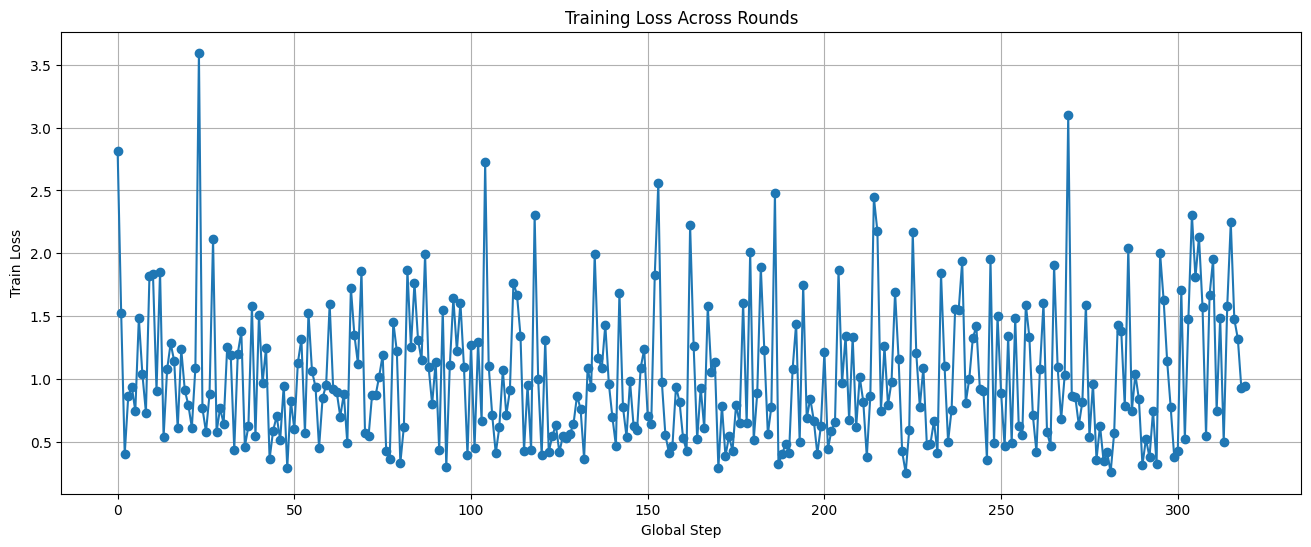

In [22]:
# Training Loss
student_train_df = df[(df['role'] == 'student') & (df['phase'] == 'train')]
student_train_df = student_train_df.sort_values(by=["round", "step"]).reset_index(drop=True)
student_train_df["global_step"] = range(len(student_train_df))

plt.figure(figsize=(16, 6))
plt.plot(student_train_df["global_step"], student_train_df["train_loss"], marker='o', linestyle='-')
plt.title("Training Loss Across Rounds")
plt.xlabel("Global Step")
plt.ylabel("Train Loss")
plt.grid(True)
plt.show()

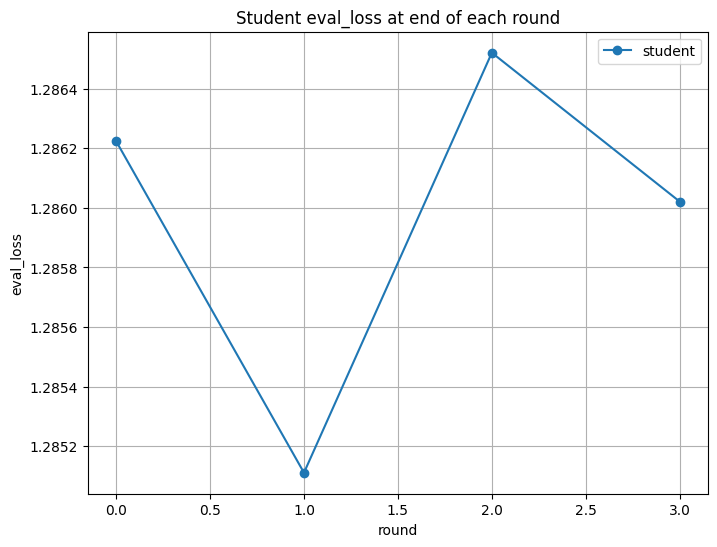

In [31]:
# Student end‐of‐round eval_loss
plt.figure(figsize=(8,6))
df_student_eval = df[(df.phase=="eval") & (df.role=="student")]
plt.plot(df_student_eval["round"], df_student_eval["eval_loss"], marker="o", linestyle="-", color="C0", label="student")
plt.xlabel("round")
plt.ylabel("eval_loss")
plt.title("Student eval_loss at end of each round")
plt.legend()
plt.grid(True)
plt.show()

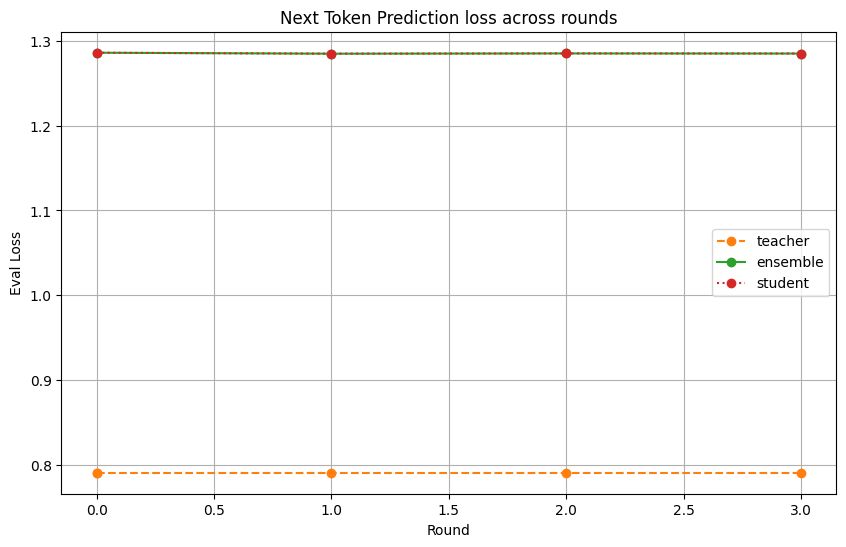

In [33]:
# Student vs Teacher vs Ensemble
plt.figure(figsize=(10, 6))
df_eval = df[df.phase=="eval"]
df_teacher = df_eval[df_eval.role=="teacher"].sort_values("round")
df_ensemble = df_eval[df_eval.role=="ensemble"].sort_values("round")
df_student = df_eval[df_eval.role=="student"].sort_values("round")

plt.plot(
    df_teacher["round"],
    df_teacher["eval_loss"],
    marker="o", linestyle="--", color="C1", label="teacher"
)
plt.plot(
    df_ensemble["round"],
    df_ensemble["eval_loss"],
    marker="o", linestyle="-", color="C2", label="ensemble"
)
plt.plot(
    df_ensemble["round"],
    df_ensemble["eval_loss"],
    marker="o", linestyle=":", color="C3", label="student"
)

plt.xlabel("Round")
plt.ylabel("Eval Loss")
plt.title("Next Token Prediction loss across rounds")
plt.legend()
plt.grid(True)
plt.show()


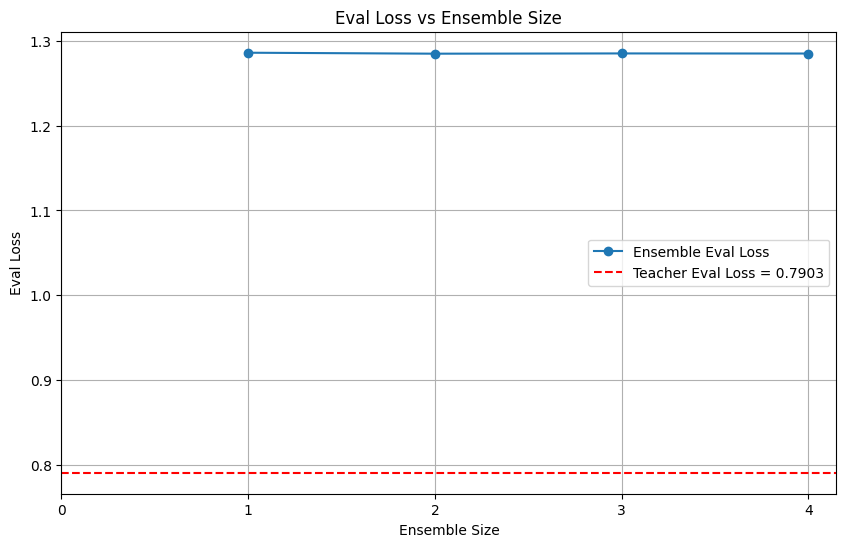

In [36]:
eval_df = df[(df["phase"] == "eval") & (df["role"].isin(["teacher", "ensemble"]))]

eval_df = eval_df.dropna(subset=["ensemble_size"])
eval_df["ensemble_size"] = eval_df["ensemble_size"].astype(int)

loss_vs_size = eval_df.pivot_table(
    index="ensemble_size",
    columns="role",
    values="eval_loss",
    aggfunc="first"
).sort_index().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(loss_vs_size["ensemble_size"], loss_vs_size["ensemble"], label="Ensemble Eval Loss", marker='o')

if "teacher" in loss_vs_size.columns and loss_vs_size["teacher"].notna().any():
    teacher_loss = loss_vs_size["teacher"].dropna().iloc[0]
    plt.axhline(y=teacher_loss, color='red', linestyle='--', label=f"Teacher Eval Loss = {teacher_loss:.4f}")

plt.title("Eval Loss vs Ensemble Size")
plt.xlabel("Ensemble Size")
plt.ylabel("Eval Loss")
plt.xticks(loss_vs_size["ensemble_size"])
plt.grid(True)
plt.legend()
plt.show()